##EECS 504 Final Project: Fine Tuned SAM
###Authors: Soumyadeep Dasgupta, Nicholas David, Jingxian Li, Yujie Liu

### Inspired by :
####https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb
####https://github.com/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb

In [61]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install -q monai
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-grk3cfkz
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-grk3cfkz
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [62]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify
import random
from scipy import ndimage
import matplotlib.colors as mcolors

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Input 42 large images imported. output.tiff has the grayscale images and the binary_labels_matrix.tiff has the binary images label of the matrix phase (Class 0)
large_images = tifffile.imread("/content/drive/MyDrive/Colab Notebooks/output.tiff")
large_masks = tifffile.imread("/content/drive/MyDrive/Colab Notebooks/binary_labels_matrix.tiff")

# Optimal Patch size.
patch_size = 256
step = 256

# Patching Images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Patching Labelled Masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Deleting Empty Masks to prevent Error in Empty Maks Tensor
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]

filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

print("Image shape:", filtered_images.shape)
print("Mask shape:", filtered_masks.shape)

Image shape: (336, 256, 256)
Mask shape: (336, 256, 256)


In [65]:
from datasets import Dataset
from PIL import Image

dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

dataset = Dataset.from_dict(dataset_dict)

In [66]:
# Bounding Box generator Helper Function

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [67]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):

  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [68]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [69]:
# Instance of SAM Dataset
from torch.utils.data import DataLoader

train_dataset = SAMDataset(dataset=dataset, processor=processor)
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)
batch = next(iter(train_dataloader))

In [70]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")
# only gradients calculated for mask encoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [71]:
from torch.optim import Adam
import monai

# Optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:

from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 168/168 [02:56<00:00,  1.05s/it]


EPOCH: 0
Mean loss: 0.3889491455185981


100%|██████████| 168/168 [02:52<00:00,  1.03s/it]


EPOCH: 1
Mean loss: 0.3672817692692791


100%|██████████| 168/168 [02:53<00:00,  1.03s/it]


EPOCH: 2
Mean loss: 0.35612040225948605


100%|██████████| 168/168 [02:52<00:00,  1.03s/it]

EPOCH: 3
Mean loss: 0.3507155847868749


In [72]:
# Model State Dictionary saved
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/micro_model_checkpoint_final_matrix.pth")

**Inference**

In [82]:
from transformers import SamModel, SamConfig, SamProcessor
import torch
# Load model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# New instance of the model
SAM_model = SamModel(config=model_config)
my_micro_model = SamModel(config=model_config)
# Model updated with the weights
my_micro_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/micro_model_checkpoint_matrix.pth"))
SAM_model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/micro_model_checkpoint_final_matrix.pth"))

<All keys matched successfully>

In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"
my_micro_model.to(device)
SAM_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [84]:
idx = random.randint(0, filtered_images.shape[0]-1)

idx = 73

# load image
test_image = dataset[idx]["image"]

# Generate box prompt
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# Input Processor
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Input shifted to GPU
inputs = {k: v.to(device) for k, v in inputs.items()}

my_micro_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_micro_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))


# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()

medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


In [85]:
SAM_model.eval()

# forward pass
with torch.no_grad():
    outputs_SAM = SAM_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob_SAM = torch.sigmoid(outputs_SAM.pred_masks.squeeze(1))


# convert soft mask to hard mask
medsam_seg_prob_SAM = medsam_seg_prob_SAM.cpu().numpy().squeeze()

medsam_seg_SAM = (medsam_seg_prob_SAM > 0.5).astype(np.uint8)


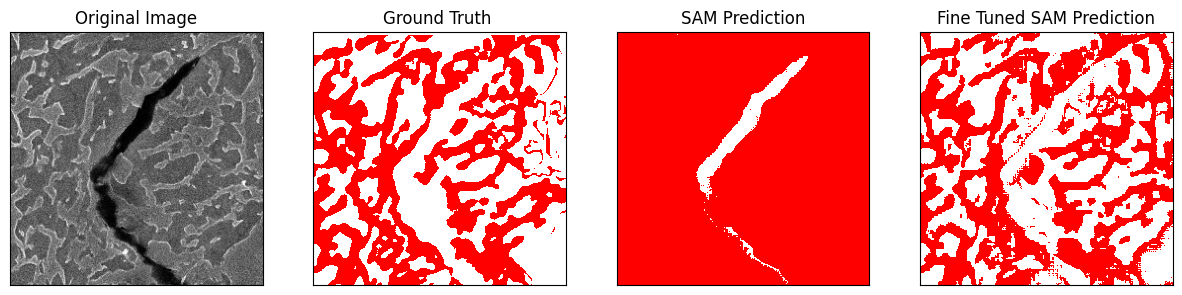

In [86]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

cmap = mcolors.ListedColormap(['white','red'])

axes[0].imshow(np.array(test_image), cmap='gray')
axes[0].set_title("Original Image")

axes[1].imshow(ground_truth_mask,cmap=cmap)
axes[1].set_title("Ground Truth ")

axes[2].imshow(medsam_seg_SAM, cmap=cmap)
axes[2].set_title("SAM Prediction")

axes[3].imshow(medsam_seg, cmap=cmap)
axes[3].set_title("Fine Tuned SAM Prediction")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

In [87]:
intersection = np.sum(medsam_seg * ground_truth_mask)
union = np.sum(medsam_seg) + np.sum(ground_truth_mask) - intersection

# Calculate the IoU score
iou = intersection / union

print("IoU Score:", iou)

IoU Score: 0.72712819368515
